In [72]:
# Importamos las librerías necesarias para el análisis de datos y visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew, kurtosis, norm
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Enlace compartido del archivo CSV en Google Drive
enlace_drive = "https://drive.google.com/uc?id=1c1l3OMUFjQWcydV0srKe95LLEfkBMKia"

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv(enlace_drive)

In [2]:
# Obtener estadísticas descriptivas del DataFrame
print("\nEstadísticas descriptivas del DataFrame:")
df.describe()


Estadísticas descriptivas del DataFrame:


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.357394,0.596439,220112.733333,0.594188,0.100245,4.829333,0.203376,-8.509339,0.741333,0.098966,120.405761,3.902667,0.497321,0.602667
std,0.338405,0.172036,65587.690483,0.253301,0.259921,3.636001,0.177609,5.039488,0.438194,0.104715,28.378116,0.400091,0.239615,0.489673
min,0.000001,0.107000,33840.000000,0.009250,0.000000,0.000000,0.024000,-29.601000,0.000000,0.023400,55.747000,1.000000,0.033200,0.000000
25%,0.037150,0.480000,185490.250000,0.423250,0.000000,1.000000,0.094550,-10.173500,0.000000,0.035900,98.998000,4.000000,0.297000,0.000000
50%,0.244500,0.606000,215108.500000,0.631500,0.000010,5.000000,0.129000,-7.270000,1.000000,0.048750,120.104500,4.000000,0.483000,1.000000
75%,0.678500,0.715750,244236.750000,0.804750,0.002245,8.000000,0.264750,-5.097750,1.000000,0.113000,138.074750,4.000000,0.684500,1.000000
max,0.994000,0.986000,675360.000000,0.995000,0.967000,11.000000,0.979000,-0.533000,1.000000,0.721000,204.162000,5.000000,0.975000,1.000000


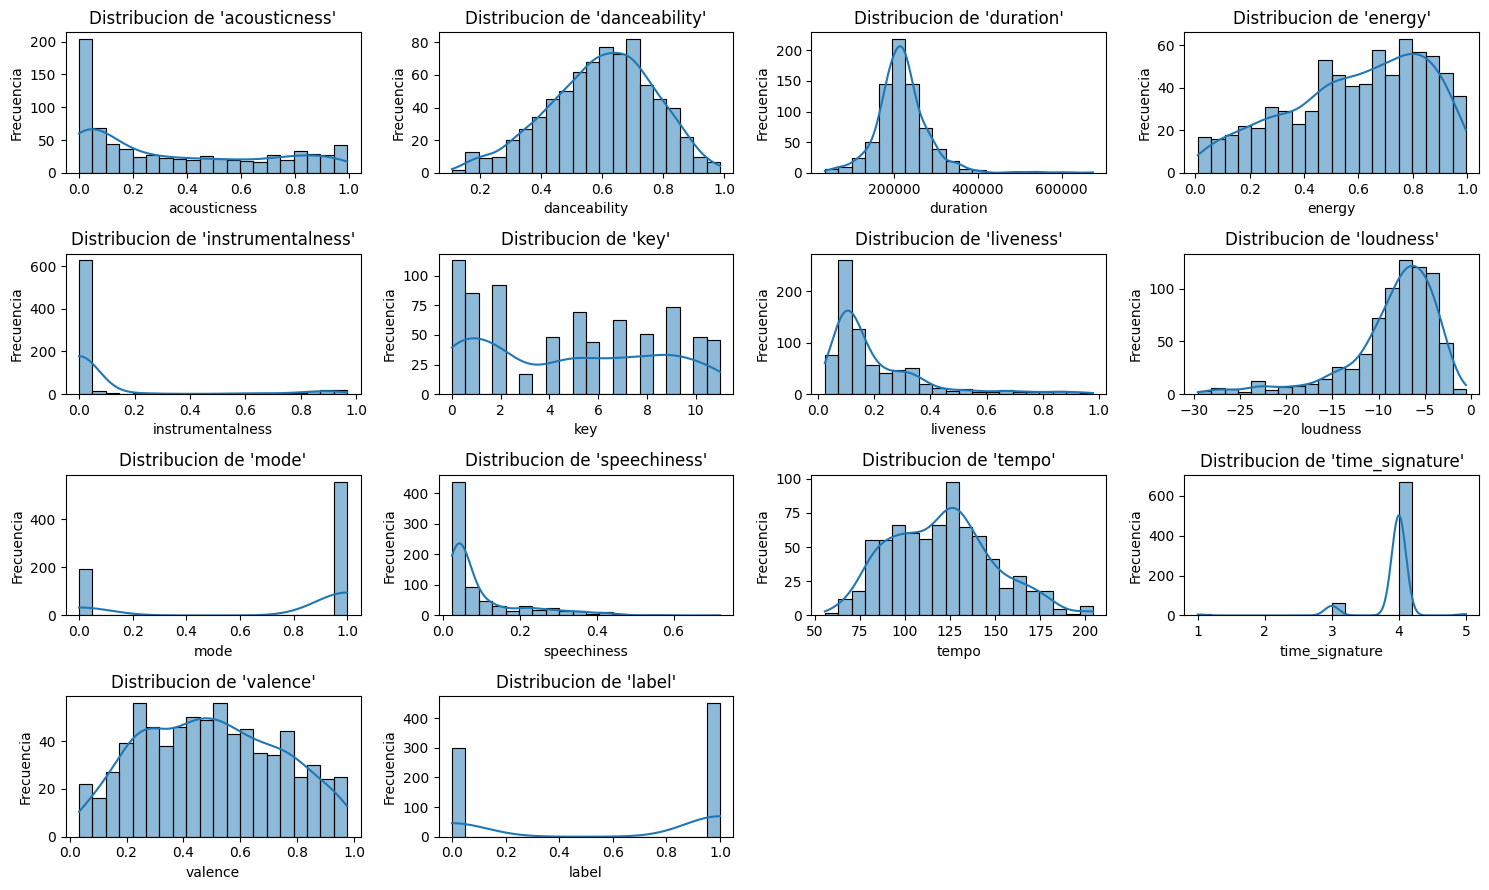

In [3]:
# Calcular el número de filas necesarias para acomodar todas las variables.
num_variables = len(df.columns)
num_rows = -(-len(df.columns) // 5)  #Para garantizar que se tracen todas las variables.

# Crear una sola figura con 5 columnas.
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 3*num_rows))

# Aplana la matriz de ejes si num_rows es 1, para que pueda indexarse ​​de manera consistente
axes = axes.flatten() if num_rows > 1 else [axes]

# Iterar a través de cada variable y trazar
for i, column in enumerate(df.columns):
    ax = axes[i]  # Seleccionar el subplot apropiado
    sns.histplot(df[column], kde = True, ax = ax, bins = 20)  # Histograma con KDE
    ax.set_title(f"Distribucion de '{column}'")
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

# Ocultar subplots no utilizados
fig.delaxes(axes[14])
fig.delaxes(axes[15])

plt.tight_layout()  # Ajustar Layout para evitar superposiciones
plt.show()

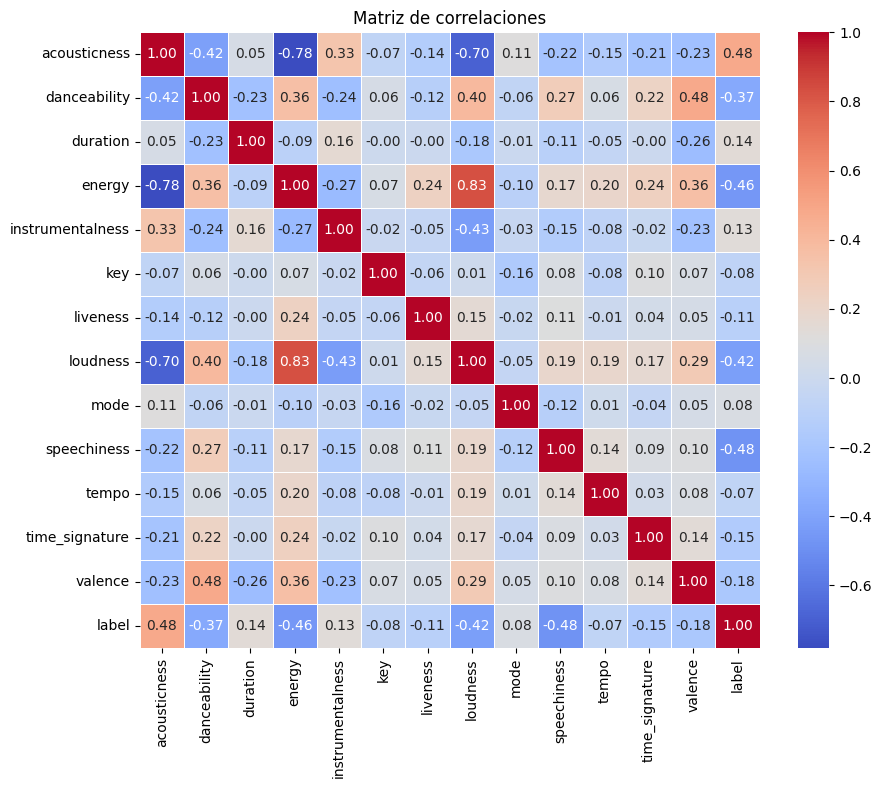

In [73]:
# Calcular la matriz de correlaciones
correlation_matrix = df.corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlaciones')
plt.show()

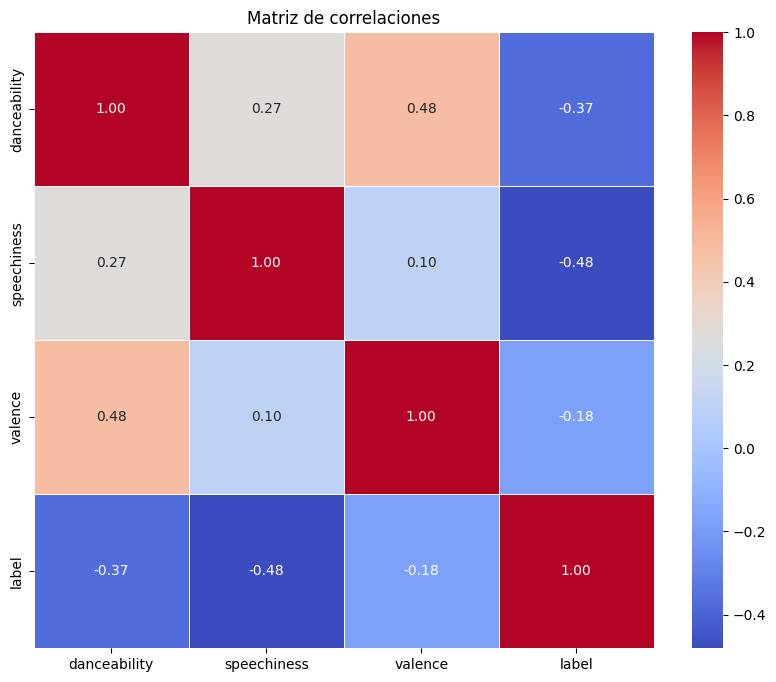

In [82]:
df = pd.read_csv(enlace_drive)
df.drop(['tempo','key','mode','duration','instrumentalness','liveness','time_signature','acousticness', 'energy', 'loudness'], axis = 1, inplace = True)
correlation_matrix = df.corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlaciones')
plt.show()

In [5]:
# Definimos una funcion para comprobar la normalidad de una variable
def test_normalidad(data, p_thres = 0.05):
    mean, std = norm.fit(data)

    if std == 0:
        return 'No normal', 1e-8

    normal = norm(loc = mean, scale = std)
    _, p_value = stats.kstest(data, normal.cdf)

    if p_value > p_thres:
        normality = "Normal"
    else:
        normality = "No normal"

    return normality, p_value

In [6]:
def dataframe_statistics(dataframe):
    data = dataframe.copy()

    resultados = {}

    for col in data.columns:
        # Check data type to handle non-numeric columns
        if pd.api.types.is_numeric_dtype(data[col]):
            data_stats = data[col].describe(percentiles=[0.25, 0.75])
            data_stats['skewness'] = skew(data[col])
            data_stats['kurtosis'] = kurtosis(data[col])
            data_stats['normalness'], _ = test_normalidad(data[col], 0.05)
            data_stats['uniques'] = data[col].nunique()
            data_stats['null count'] = data[col].isnull().sum()
            data_stats['data type'] = type(data[col][0])
            resultados[col] = data_stats
        else:
            resultados[col] = {'count': data[col].count(), 'unique': data[col].nunique(), 'top': data[col].mode().iloc[0]}

    # Display the results in a table format
    print(tabulate(pd.DataFrame(resultados), headers='keys', tablefmt='grid'))


In [7]:
def plot_function(data, type):
    num_plots = min(16, len(data.columns))
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axs = axs.ravel()

    for i, col in enumerate(data.select_dtypes(include=[np.number])): 
        if i >= num_plots:
            break
        if type == 'QQPlot': 
            sm.qqplot(data[col], line='r', ax=axs[i], fit=True)
            axs[i].set_xlabel("Theoretical Quantiles")
            axs[i].set_ylabel("Sample Quantiles")
            axs[i].set_title(f"{col}")
        elif type == 'BoxPlot':
            sns.boxplot(y=data[col], orient="v", ax=axs[i])  
            axs[i].set_xlabel("")
            axs[i].set_ylabel(col)
            axs[i].set_title(f"Boxplot de {col}")

    # Remove unused subplots
    for j in range(num_plots, num_rows * num_cols):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

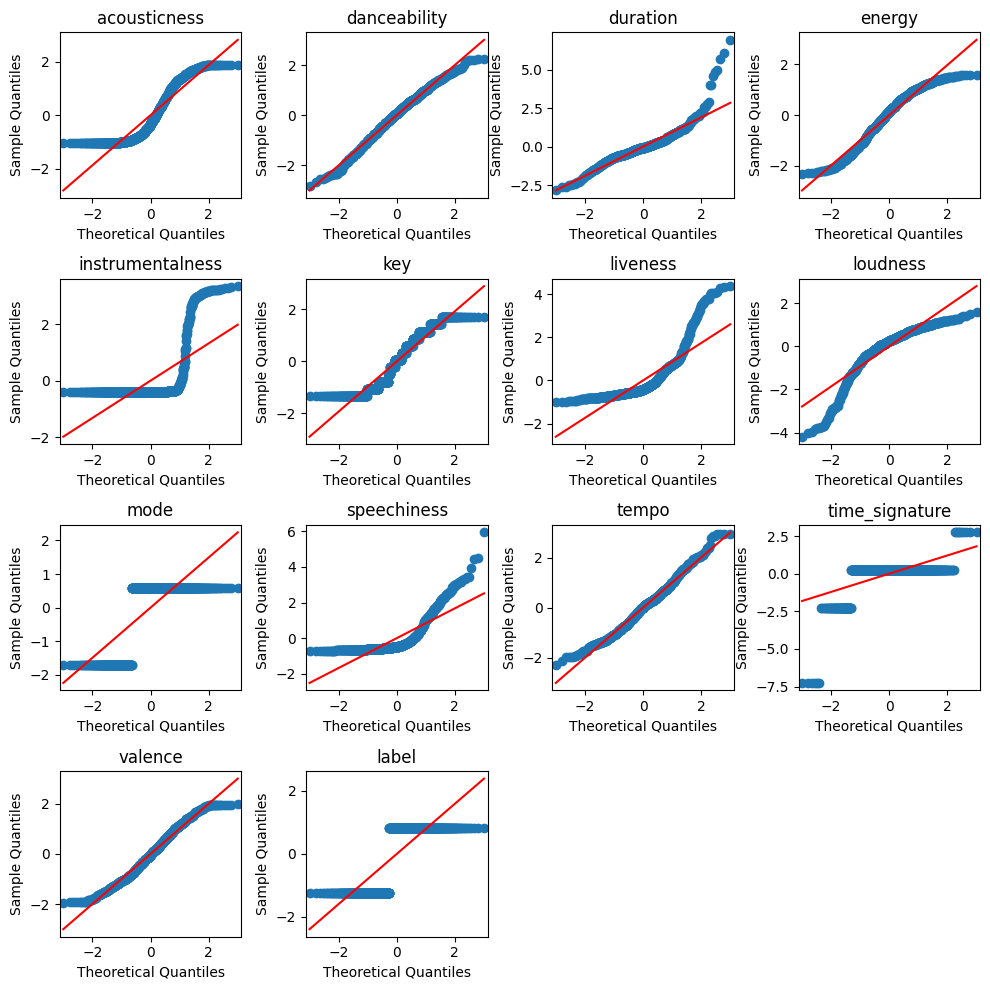

In [8]:
plot_function(df, 'QQPlot')

In [9]:
dataframe_statistics(df)

+------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-----------------------+
|            | acousticness            | danceability            | duration              | energy                  | instrumentalness        | key                   | liveness                | loudness                | mode                  | speechiness             | tempo                   | time_signature        | valence                 | label                 |
+============+=========================+=========================+=======================+=========================+=========================+=======================+=========================+=========================+=======================+====================

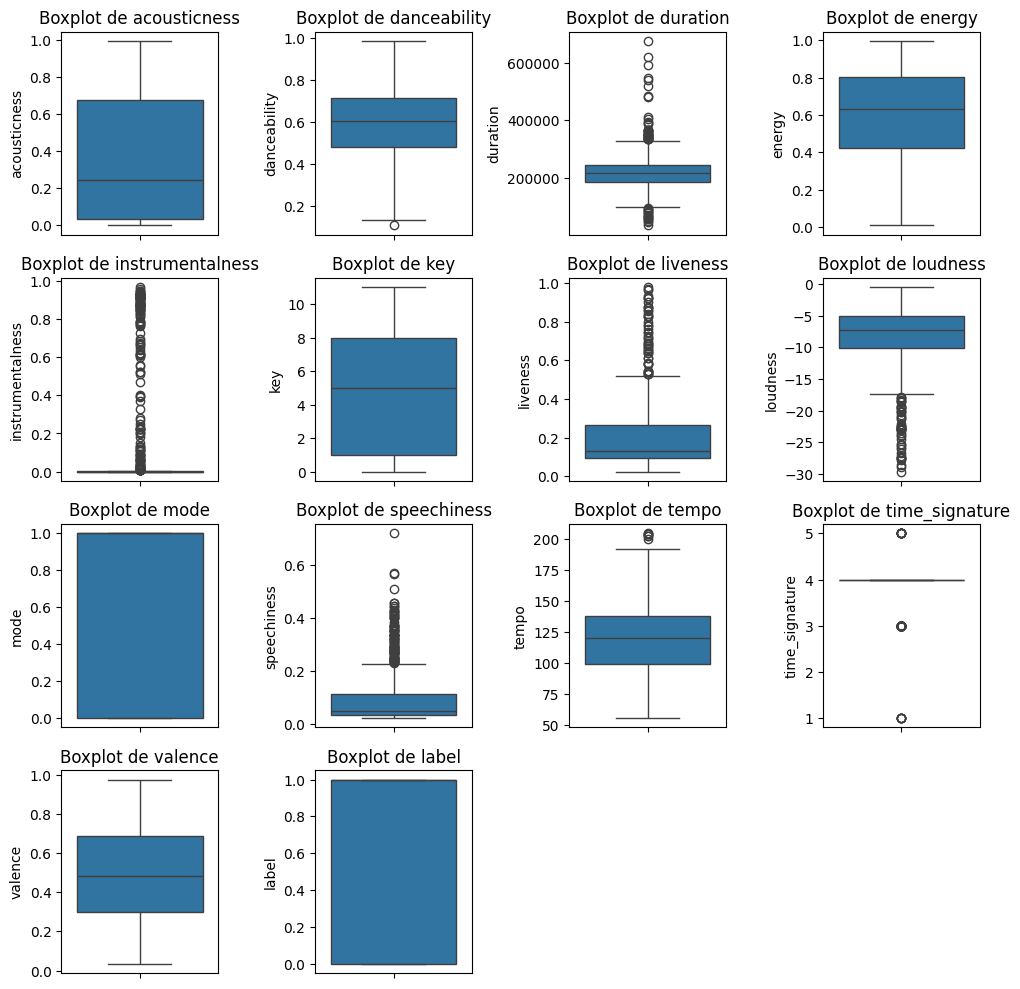

In [10]:
plot_function(df, "BoxPlot")

In [11]:
def compute_missing_data(data, method, testing = False, percentage = 0.15):
    modified_data = data.copy()
    
    if testing:
        for column in data:
            # Seleccionar aleatoriamente los indices para computar los valores faltantes
            indices_to_null = np.random.choice(data.index, size=int(len(data) * percentage), replace=False)
            modified_data.loc[indices_to_null, column] = np.nan
    
    # Mean, median, mode y arbitrary pueden ser calculados variable por variable
    if method in ['Mean', 'Median', 'Mode', 'Arbitrary']:
        for column in data:
            # Para cada columna (variable), computar los valores faltantes segun el metodo especificado
            for index in modified_data[modified_data[column].isnull()].index:
                if method == 'Mean':
                    value = data[column].mean()
                elif method == 'Median':
                    value = data[column].median()
                elif method == 'Mode':
                    value = data[column].mode().iloc[0]
                elif method == 'Arbitrary':
                    value = np.random.uniform(data[column].min(), data[column].max())
                else:
                    value = np.nan

                if isinstance(value, np.ndarray):
                    value = value[0]
                value = data[column].dtype.type(value)

                modified_data.loc[index, column] = value
    
    # MICE y KNN requieren el dataframe completo para ser calculados
    elif method in ['KNN', 'MICE']:
        if method == 'KNN':
            imputer = KNNImputer(n_neighbors=5)
            imputed = imputer.fit_transform(modified_data)
            modified_data = pd.DataFrame(imputed, columns = modified_data.columns)
        elif method == 'MICE':
            imputer = IterativeImputer()
            imputed = imputer.fit_transform(modified_data)
            modified_data = pd.DataFrame(imputed, columns = modified_data.columns)
    
    return modified_data

In [12]:
def handle_outliers(data, method, imputation_method = 'KNN', winsorization_rate = 0.05):
    original_data = data.copy()
    modified_data = data.copy()

    if method == 'Imputacion':
        for column in modified_data.columns:
            q1 = np.percentile(modified_data[column], 25)
            q3 = np.percentile(modified_data[column], 75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            upper_limit = q3 + 1.5 * iqr

            modified_data[column] = np.where(modified_data[column] < lower_limit, np.nan, np.where(modified_data[column] > upper_limit, np.nan, modified_data[column]))

        # cambia todos los numeros que esten fuera de los limites superior e inferior a np.nan
        outlierless_data = compute_missing_data(modified_data, imputation_method, False, None)
        return outlierless_data
    
    for column in modified_data.columns:
        q1 = np.percentile(original_data[column], 25)
        q3 = np.percentile(original_data[column], 75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr

        if method == 'Trimming':
            # Quita todas las filas de data que tengan numeros fuera de los limites superior e inferior
            mask = (modified_data[column] >= lower_limit) & (modified_data[column] <= upper_limit)
            modified_data = modified_data[mask].reset_index(drop=True)
            outlierless_data = modified_data.loc[mask]
        elif method == 'Capping':
            # Cambia los valores de los numeros que estan fuera de los limites superior e inferior a su respectivo limite
            modified_data[column] = np.where(modified_data[column] < lower_limit, lower_limit, np.where(modified_data[column] > upper_limit, upper_limit, modified_data[column]))
            outlierless_data = modified_data
        elif method == 'Winsorization':
            lower_winsor = np.percentile(modified_data[column], 100 * winsorization_rate)
            upper_winsor = np.percentile(modified_data[column], 100 * (1 - winsorization_rate))
            modified_data[column] = np.where(modified_data[column] < lower_winsor, lower_winsor, np.where(modified_data[column] > upper_winsor, upper_winsor, modified_data[column]))
            outlierless_data = modified_data
        else:
            print(f"No hubo match {method}")

    return outlierless_data

In [13]:
def transform_data(data, method, p_thres):
    modified_data = data.copy()
    method_used = []

    if method == 'Auto':
        for column in modified_data.columns:
            methods = ['Exp', 'BoxCox', 'Yeo-Johnson']
            
            # Probamos todas las transformaciones
            # Transformacion exponencial
            exp_data = np.exp(modified_data[column])
            _, p_val_exp = test_normalidad(exp_data, p_thres = p_thres)

            print(exp_data)

            # Transformacion BoxCox
            pt = PowerTransformer(method = 'box-cox')
            if (modified_data[column] <= 0.0).any():
                # BoxCox no se puede hacer con valores negativos asi que le asignamos un valor muy malo para no tenerlo en cuenta
                box_data = modified_data[column]
                p_val_box = 1e-20
            else:
                box_data = pt.fit_transform(modified_data[column].values.reshape(-1, 1))
                _, p_val_box = test_normalidad(box_data, p_thres = p_thres)

            print(box_data)

            # Transformacion Yeo-Johnson
            pt = PowerTransformer(method = 'yeo-johnson')
            yeo_data = pt.fit_transform(modified_data[column].values.reshape(-1, 1))
            _, p_val_yeo = test_normalidad(yeo_data, p_thres = p_thres)

            print(yeo_data)
            
            # Transformacion Cuartiles
            # IMPORTANTE: Ignoramos este metodo porque es medio 'trampa', ya que fuerza todo a una distribucion normal y solo funciona para grandes cantidades de datos
            #qt = QuantileTransformer(n_quantiles = 100, output_distribution='normal')
            #_, p_val_qt = test_normalidad(qt.fit_transform(modified_data[[column]]), p_thres = p_thres)

            data = [exp_data, box_data, yeo_data]

            print(data)

            p_vals = [p_val_exp, p_val_box, p_val_yeo]
            index = np.argmax(p_vals)
            modified_data[column] = data[index]
            method_used.append(methods[index])
        return modified_data, method_used
    else:
        for column in modified_data.columns:
            # Si la variable ya es normal, no hace falta transformarla
            if test_normalidad(modified_data[column], p_thres = p_thres) == 'Normal':
                continue
                
            if method == 'Exp':
                if (modified_data[column] > 20).any():
                    print('Los numeros son demasiado grandes para hacer transformacion exponencial')
                    method_used.append('none')
                    continue
                modified_data[column] = np.exp(modified_data[column])
                method_used.append('Exp')
            elif method == 'box-cox':
                if (modified_data[column] <= 0.0).any():
                    print('Hay numeros negativos o cero, no se puede hacer box-cox')
                    method_used.append('none')
                    continue
                pt = PowerTransformer(method = method)
                modified_data[column] = pt.fit_transform(modified_data[column].values.reshape(-1, 1))
                method_used.append('box-cox')
            elif method == 'yeo-johnson':
                pt = PowerTransformer(method = method)
                modified_data[column] = pt.fit_transform(modified_data[column].values.reshape(-1, 1))
                method_used.append('Yeo-Johnson')
            elif method == 'Cuartiles':
                qt = QuantileTransformer(n_quantiles = 100, output_distribution='normal')
                modified_data[column] = qt.fit_transform(modified_data[[column]])
                method_used.append('Cuartiles')
            else:
                print(f"No hubo match {method}")
    return modified_data, method_used

In [14]:
def reduce_dimensionality(data, method, corr_thres = 0.95, var_thres = 0.01, normality_thres = 0.01, explained_var = 0.99, do_ica = False, filter_non_normal = False):
    modified_data = data.copy()

    if method == 'Filter':
        # Remover variables que tienen varianza muy pequeña o son muy no normales
        for column in modified_data.columns:
            var = modified_data[column].var()
            
            _, p_val = test_normalidad(modified_data[column], normality_thres)

            if var < var_thres:
                print(f'Quitando {column} por varianza {var}')
                modified_data.drop(column, axis=1, inplace=True)
            elif p_val < normality_thres and filter_non_normal:
                print(f'Quitando {column} por no normal {p_val}')
                modified_data.drop(column, axis=1, inplace=True)

        # Remover variables de alta correlacion
        corr_matrix = np.corrcoef(modified_data, rowvar=False)
        # Llenar la diagonal de la matriz de correlacion de ceros para evitar considerar autocorrelacion
        np.fill_diagonal(corr_matrix, 0)
        corr_mask = np.abs(corr_matrix) < corr_thres
        modified_data = modified_data.loc[:, np.all(corr_mask, axis=0)]

    elif method == 'Projection':
        # Before performing PCA, data should be scaled
        scaler = StandardScaler()
        modified_data = scaler.fit_transform(modified_data)

        # Perform PCA
        pca = PCA(explained_var)
        modified_data = pca.fit_transform(modified_data)
        print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

        # Perform ICA
        if pca.n_components_ > 1 and do_ica:
            ica = FastICA()
            modified_data = ica.fit_transform(modified_data)

        # Transform back into a DataFrame
        modified_data = pd.DataFrame(modified_data, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])
    else:
        print(f"No hubo match {method}")

    return modified_data


In [15]:
# Calcular la media de cada variable
means = []
stds = []
for method in ['Original', 'Mean', 'Mode', 'Median', 'Arbitrary', 'KNN', 'MICE']:
    if method == 'Original':
        means.append(df.mean())
        stds.append(df.std())
        continue
    means.append(compute_missing_data(df, method = method, testing = True, percentage = 0.15).mean())
    stds.append(compute_missing_data(df, method = method, testing = True, percentage = 0.15).std())

summary_df = pd.concat(means, axis=1)
summary_df.columns = ['Original', 'Mean', 'Mode', 'Median', 'Arbitrary', 'KNN', 'MICE']
print(tabulate(summary_df, headers='keys', tablefmt='psql'))

+------------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+
|                  |       Original |           Mean |           Mode |         Median |     Arbitrary |            KNN |           MICE |
|------------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------|
| acousticness     |      0.357394  |      0.358664  |      0.457379  |      0.342902  |      0.378578 |      0.347302  |      0.356815  |
| danceability     |      0.596439  |      0.598148  |      0.588359  |      0.598785  |      0.586507 |      0.599346  |      0.597622  |
| duration         | 220113         | 220682         | 218726         | 220048         | 237823        | 217935         | 221095         |
| energy           |      0.594188  |      0.596338  |      0.603165  |      0.605535  |      0.579812 |      0.593176  |      0.595959  |
| instrumentalness |      0

In [16]:
summary_df = pd.concat(stds, axis=1)
summary_df.columns = ['Original', 'Mean', 'Mode', 'Median', 'Arbitrary', 'KNN', 'MICE']
print(tabulate(summary_df, headers='keys', tablefmt='psql'))

+------------------+--------------+---------------+--------------+---------------+---------------+---------------+---------------+
|                  |     Original |          Mean |         Mode |        Median |     Arbitrary |           KNN |          MICE |
|------------------+--------------+---------------+--------------+---------------+---------------+---------------+---------------|
| acousticness     |     0.338405 |     0.313775  |     0.384525 |     0.318926  |      0.335124 |     0.321069  |     0.3283    |
| danceability     |     0.172036 |     0.159267  |     0.162485 |     0.162104  |      0.185677 |     0.160523  |     0.163948  |
| duration         | 65587.7      | 60173.2       | 62176.3      | 60703.6       | 106387        | 61657.4       | 59657.5       |
| energy           |     0.253301 |     0.23269   |     0.231391 |     0.23499   |      0.261174 |     0.236119  |     0.250389  |
| instrumentalness |     0.259921 |     0.230241  |     0.243318 |     0.242239  | 

Explorando unicamente la media y desviacion estandar de las variables una vez que se le aplica imputacion de datos, podemos sacar algunas conclusiones:
1. El metodo 'Arbitrary' debe ser imputado manualmente, o con un criterio mas riguroso que un valor al azar, ya que es el que mayor diferencias presenta con respecto al dataset original
2. Mientras mayor es la cantidad de datos faltantes, mas se aleja la moda del dataset original
3. Mientras mas grande es la magnitud de una variable, la desviacion estandar tiende a ser mayor, y mayor se vuelve la diferencia entre los datasets con datos imputados y el dataset original


In [17]:
outlier_percentages = []

for method in ['Original', 'Imputacion', 'Capping', 'Trimming', 'Winsorization']:
    outlier_counts = []

    if method == 'Original':
        # Calcular cantidad de outliers para cada feature en el dataframe original 
        for column in df.columns:
            q1 = np.percentile(df[column], 25)
            q3 = np.percentile(df[column], 75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            upper_limit = q3 + 1.5 * iqr
            outlier_count = ((df[column] < lower_limit) | (df[column] > upper_limit)).sum()
            outlier_counts.append(outlier_count / len(df[column]) * 100)
        dataframe_statistics(df)
        print('\n')
    else:
        # Calcular cantidad de outliers para cada feature luego de aplicar un metodo de tratamiento de outliers
        new_df = handle_outliers(df, method=method, imputation_method='MICE', winsorization_rate=0.25)
        for column in new_df.columns:
            q1 = np.percentile(df[column], 25)
            q3 = np.percentile(df[column], 75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5 * iqr
            upper_limit = q3 + 1.5 * iqr
            outlier_count = ((new_df[column] < lower_limit) | (new_df[column] > upper_limit)).sum()
            outlier_counts.append(outlier_count / len(new_df[column]) * 100)
        dataframe_statistics(new_df)
        print('\n')
    
    # Calculo de porcentajes de outliers
    total_obs = len(df)
    outlier_percentages.append(outlier_counts)

summary_df = pd.DataFrame(outlier_percentages, index=['Original (%)', 'Imputacion (%)', 'Capping (%)', 'Trimming (%)', 'Winsorization (%)'], columns=df.columns)
print(tabulate(summary_df.T, headers='keys', tablefmt='psql'))

+------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-----------------------+
|            | acousticness            | danceability            | duration              | energy                  | instrumentalness        | key                   | liveness                | loudness                | mode                  | speechiness             | tempo                   | time_signature        | valence                 | label                 |
+============+=========================+=========================+=======================+=========================+=========================+=======================+=========================+=========================+=======================+====================

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10252\3538185400.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_stats['skewness'] = skew(data[col])
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10252\3538185400.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_stats['kurtosis'] = kurtosis(data[col])
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10252\3538185400.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_stats['skewness'] = skew(data[col])
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10252\3538185400.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catas

+------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-------------------------+-----------------------+-------------------------+-----------------------+
|            | acousticness            | danceability            | duration              | energy                  | instrumentalness        | key                   | liveness                | loudness                | mode                  | speechiness             | tempo                   | time_signature        | valence                 | label                 |
+============+=========================+=========================+=======================+=========================+=========================+=======================+=========================+=========================+=======================+====================

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10252\3538185400.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_stats['skewness'] = skew(data[col])
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10252\3538185400.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_stats['kurtosis'] = kurtosis(data[col])


En este punto se aplicó tratamiento de outliers con los distintos metodos implementados (Imputacion, Capping, Trimming y Winsorization). 
1. En el caso de Trimming, que consiste en eliminar datos cuando tienen parametros fuera de los limites, se terminaron eliminando 70% de los datos. Una de las ventajas de esto es que dos variables que antes no eran normales, ahora si lo son (duration y loudness). La desventaja es que, sin una justificacion fuerte para eliminar esos datos, no se puede simplemente eliminarlos. Estos outliers podrian aportar informacion al modelo. 
2. Para el caso de Capping y Winsorization, era de esperarse que no afectara a la normalidad de las variables. Ambos metodos consisten en truncar la variable, por lo que todos los outliers pasan a estar en los limites puestos por cada metodo.
3. Por ultimo, en el caso de Imputacion, uno esperaria que calculando los outliers como si fuesen informacion faltante, sucediera algo como lo que sucedió en Trimming, que algunas variables se normalizaron. Sin embargo, ese no fue el caso. Esto podria, tentativamente, confirmar el hecho de que los outliers aportan informacion al modelo.

Cabe aclarar que los porcentajes que se muestran en las tablas de imputacion, capping, trimming y winsorization son con respecto a los valores Q1, Q3 (y por lo tanto IQR) del dataframe original. Una vez eliminados los outliers, se tendria que volver a calcular los nuevos Q1 y Q3 del dataframe modificado, para determinar los nuevos valores que caen fuera de rango y son outliers (que seguramente hay).

In [18]:
p_values = []
for method in ['Original', 'Exp', 'box-cox', 'yeo-johnson', 'Cuartiles']:
    p_vals = []
    if method == 'Original':
        for column in df.columns:
            _, p_val = test_normalidad(df[column], p_thres = 0.05)
            p_vals.append(p_val)
        p_values.append(p_vals)
    else:
        new_df, _ = transform_data(df, method = method, p_thres = 0.05)
        for column in new_df.columns:
            _, p_val = test_normalidad(new_df[column], p_thres = 0.05)
            p_vals.append(p_val)
        p_values.append(p_vals)

summary_df = pd.DataFrame(p_values, index=['Original', 'Exp', 'box-cox', 'yeo-johnson', 'Cuartiles'], columns=df.columns)
print(tabulate(summary_df.T, headers='keys', tablefmt='psql'))

Los numeros son demasiado grandes para hacer transformacion exponencial
Los numeros son demasiado grandes para hacer transformacion exponencial
Hay numeros negativos o cero, no se puede hacer box-cox
Hay numeros negativos o cero, no se puede hacer box-cox
Hay numeros negativos o cero, no se puede hacer box-cox
Hay numeros negativos o cero, no se puede hacer box-cox
Hay numeros negativos o cero, no se puede hacer box-cox
+------------------+--------------+--------------+--------------+---------------+--------------+
|                  |     Original |          Exp |      box-cox |   yeo-johnson |    Cuartiles |
|------------------+--------------+--------------+--------------+---------------+--------------|
| acousticness     | 3.32619e-16  | 4.23648e-22  | 6.43959e-07  |  2.2105e-11   | 0.968459     |
| danceability     | 0.249605     | 0.915386     | 0.725521     |  0.889259     | 0.999974     |
| duration         | 2.57668e-08  | 2.57668e-08  | 7.95869e-06  |  7.95873e-06  | 1        

Aqui se trabajó con los distintos metodos implementados de transformacion de variables: Exponencial, Box-Cox, Yeo-Johnson y Cuantiles. Los valores de la tabla son los p_values resultado de hacer la evaluacion de normalidad de Kolmogorov-Smirnov (kstest).

Algunas variables tienen desde un inicio distribucion normal (danceability y valence). Al aplicar transformaciones, estas variables comienzan a tener un p_val mucho mas robusto. Sin embargo, aqui podemos ver porqué es importante justificar la transformacion que se elige, ya que por ejemplo una transformacion exponencial hace que la valencia deje de tener un comportamiento normal.

Otras variables como energy logran acercarse un poco a un p_val bajo el cual se podrian clasificar como normales, pero no llega lo suficiente.

Finalmente, la variable loudness (que tiene una correlacion relativamente alta con energy, entendiblemente), consiguen ser normalizadas aplicando la transformacion de box-cox o yeo-johnson.

In [138]:
# Pipeline de analisis de datos
# Copiamos el dataframe
final_df = df.copy()

# Paso 0 - Pre procesamiento de variables
# Convertimos las variables acousticness y instrumentalness en dicotomicas (instrumentalness se convierte en cancion con voz o sin voz, acousticness se convierte en cancion no acustica o algo acustica)
acousticness = (final_df['acousticness'] > 0.05).astype(int)
instrumentalness = (final_df['instrumentalness'] > 0.005).astype(int)
# Quitamos la variable de salida label ya que no deseamos aplicarle modificaciones
final_df.drop('label', axis = 1, inplace = True)
# Quitamos las variables discretas ya que no tiene sentido aplicarles transformaciones, ni tienen outliers / datos faltantes
final_df.drop(['acousticness', 'instrumentalness', 'key', 'mode', 'time_signature'], axis = 1, inplace = True)

# Paso 1 - Datos faltantes
# Verificamos si hay datos faltantes, y en caso de haberlos se computan
    # la variable method determina el metodo a utilizar para computar valores faltantes
        # los metodos implementados son Mean, Mode, Median, Arbitrary, KNN y MICE
    # la variable testing la utilizamos para borrar valores aleatoriamente, con fines educativos la definimos como True para borrar valores, ya que nuestro dataset no tiene valores faltantes
    # la variable percentage define el porcentaje de valores a borrar aleatoriamente cuando testing se define como True
        # Mean deberia utilizarse cuando la distribucion ya es normal
        # Median deberia utilizarse cuando la distribucion es oblicua o tiene outliers
        # Mode deberia utilizarse para variables categoricas
        # Arbitrary deberia utilizarse cuando la data faltante se asume MCAR (Missing Completely at Random)
        # KNN deberia utilizarse cuando la data faltante se asume MAR (Missing at Random) y pocos features
        # MCIE deberia utilizarse cuando la data faltante se asume MAR (Missing at Random) y datasets mas grandes de los cuales se pueden sacar patrones
final_df = compute_missing_data(final_df, method = 'KNN', testing = True, percentage = 0.05)

# Paso 2 - Tratamiento de outliers
# Determinamos cuales datos se consideran outliers y se selecciona un metodo de tratamiento para los mismos
    # la variable method determina el metodo a utilizar para el tratamiento de outliers
        # los metodos implementados son Imputacion, Capping, Trimming y Winsorization
    # la variable imputation_method determina el metodo de imputacion de datos cuando se selecciona Imputacion como metodo de tratamiento de outliers
    # la variable winsorization_rate determina el percentil a tener en cuenta cuando se selecciona Winsorization como metodo de tratamiento de outliers
final_df = handle_outliers(final_df, method = 'Imputacion', imputation_method = 'MICE', winsorization_rate = None)

# Paso 3 - Transformacion de variables
# Aplicamos transformaciones a aquellas variables que no tengan comportamiento normal, con el objetivo de normalizarlas
    # la variable method determina el metodo a utilizar para transformacion de variables
        # los metodos implementados son Auto, box-cox, Exp, yeo-johnson y Cuartiles
            # Auto calcula todos los metodos y elige el metodo con el mejor p_value
    # esta funcion primero determina si cada variable tiene comportamiento normal, en cuyo caso no aplica transformacion a esa variable
    # la funcion tambien cambia de box-cox a yeo-johnson en caso de que la variable tenga valores cero o negativos
final_df, methods_used = transform_data(final_df, method = 'box-cox', p_thres = 0.05)

# Paso 4 - Reduccion de dimensionalidad
# Reducimos las dimensiones para reducir la cantidad de variables no normales, linealmente dependientes, o de muy poca varianza
    # la variable method determina el metodo para reducir dimensiones
        # los metodos implementados son Filter y Projection
    # la variable corr_thres determina variables a eliminar cuando la correlacion es mas alta que este numero
    # la variable var_thres determina variables a eliminar cuando su varianza es mas baja que este numero
    # normality_thres determina variables a eliminar cuando no son normales con el porcentaje de confianza de este numero
    # explained_var determina la cantidad de componentes a utilizar en PCA de modo que se explique el valor de este numero de varianza de los datos
    # do_ica determina si se ejecuta ICA posterior a aplicar PCA
    # en caso de aplicar PCA, las variables primero se escalan, ya que PCA es sensible a la magnitud de las variables
final_df = reduce_dimensionality(final_df, method = 'Filter', corr_thres = 0.8, var_thres = 0.01, normality_thres = 0.05, explained_var = 0.95, do_ica = False)
final_df = reduce_dimensionality(final_df, method = 'Projection', corr_thres = 0.8, var_thres = 0.01, normality_thres = 0.05, explained_var = 0.93, do_ica = False)

# Paso 5
# Agregamos las variables que se removieron antes de procesar los datos
final_df = pd.concat([acousticness, instrumentalness, df['key'], df['mode'], df['time_signature'], final_df, df['label']], axis = 1)

Hay numeros negativos o cero, no se puede hacer box-cox
Explained variance ratio: [0.28639156 0.17677671 0.16457989 0.15296425 0.13934497 0.07994263]


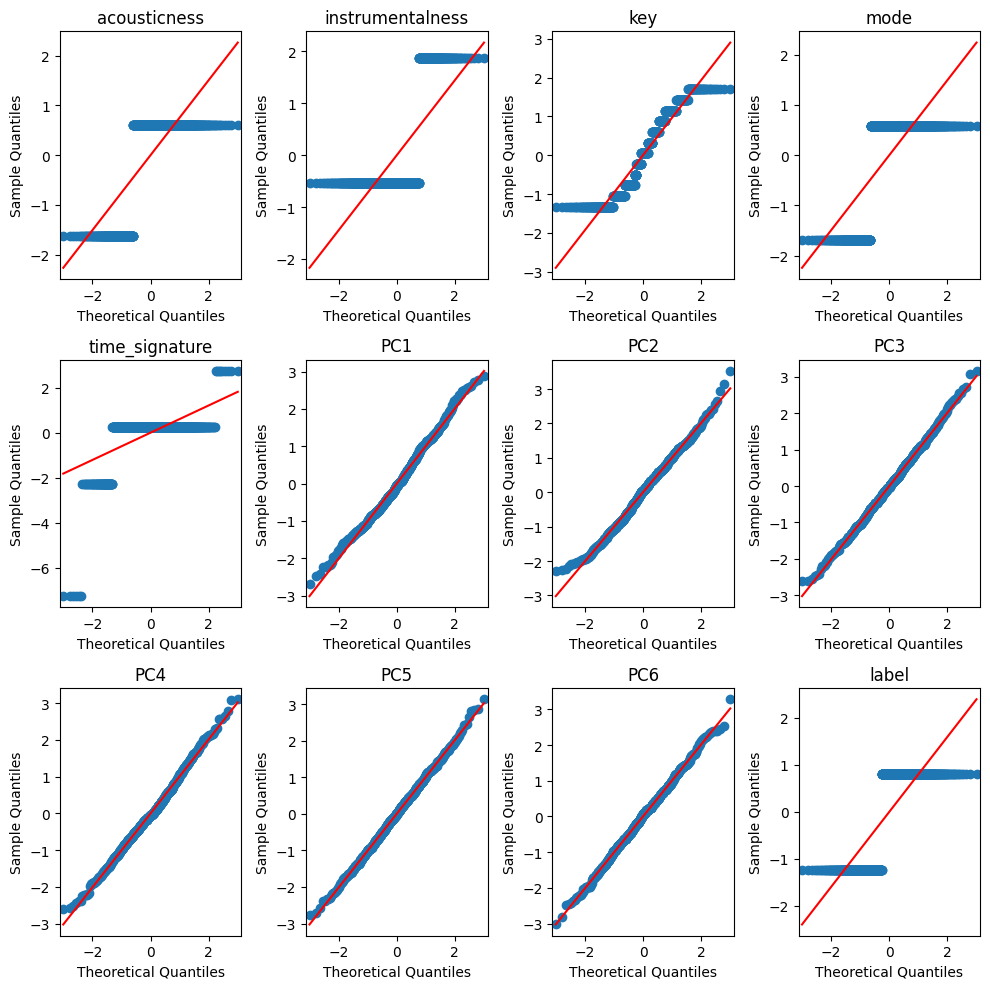

In [139]:
plot_function(final_df, 'QQPlot')

In [117]:
X_unmodified = df.drop(columns=['label'])  # Características
y_unmodified = df['label']  # Variable objetivo

X_modified = final_df.drop(columns=['label'])  # Características
y_modified = final_df['label']  # Variable objetivo

X_train_unmodified, X_test_unmodified, y_train_unmodified, y_test_unmodified = train_test_split(X_unmodified, y_unmodified, test_size=0.2, random_state=42)
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X_modified, y_modified, test_size=0.2, random_state=42)

# Inicializa los modelos
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

# Definir los hiperparámetros para cada modelo
param_grid = {
    'Decision Tree': {'max_depth': [None, 5, 10, 20]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'max_iter': [None, 500]}
}

In [118]:
scaler = StandardScaler()
X_train_unmodified = scaler.fit_transform(X_train_unmodified)
X_test_unmodified = scaler.transform(X_test_unmodified)

# Evalúa cada modelo utilizando validación cruzada
for name, model in models.items():
    scores_unmodified = cross_val_score(model, X_train_unmodified, y_train_unmodified, cv=5)
    print(f'Data original - {name}: Mean accuracy: {scores_unmodified.mean():.2f}, Std: {scores_unmodified.std():.3f}')
    scores_modified = cross_val_score(model, X_train_modified, y_train_modified, cv=5)
    print(f'Data procesada - {name}: Mean accuracy: {scores_modified.mean():.2f}, Std: {scores_modified.std():.3f}\n')

Data original - Decision Tree: Mean accuracy: 0.76, Std: 0.046
Data procesada - Decision Tree: Mean accuracy: 0.71, Std: 0.046

Data original - Random Forest: Mean accuracy: 0.83, Std: 0.054
Data procesada - Random Forest: Mean accuracy: 0.79, Std: 0.028

Data original - SVM: Mean accuracy: 0.81, Std: 0.030
Data procesada - SVM: Mean accuracy: 0.78, Std: 0.042

Data original - Logistic Regression: Mean accuracy: 0.81, Std: 0.017
Data procesada - Logistic Regression: Mean accuracy: 0.76, Std: 0.032



In [96]:
# Ajustar los hiperparámetros utilizando GridSearchCV
best_params_unmodified = {}
best_params_modified = {}
for name, model in models.items():
    grid_search_unmodified = GridSearchCV(model, param_grid[name], cv=5)
    grid_search_unmodified.fit(X_train_unmodified, y_train_unmodified)
    best_params_unmodified[name] = grid_search_unmodified.best_params_
    print(f'Data original - Best parameters for {name}: {grid_search_unmodified.best_params_}')
    
    grid_search_modified = GridSearchCV(model, param_grid[name], cv=5)
    grid_search_modified.fit(X_train_modified, y_train_modified)
    best_params_modified[name] = grid_search_modified.best_params_
    print(f'Data procesada - Best parameters for {name}: {grid_search_modified.best_params_}\n')

Data original - Best parameters for Decision Tree: {'max_depth': 5}
Data procesada - Best parameters for Decision Tree: {'max_depth': 5}

Data original - Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Data procesada - Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 50}

Data original - Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Data procesada - Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}

Data original - Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}
Data procesada - Best parameters for Logistic Regression: {'C': 1, 'max_iter': 500, 'penalty': 'l2'}



c:\Users\Nicolas\anaconda3\envs\dataAnalysis\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nicolas\anaconda3\envs\dataAnalysis\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nicolas\anaconda3\envs\dataAnalysis\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Nicolas\anaconda3\envs\dataAnalysis\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    val

In [97]:
# Evaluar el rendimiento de los modelos con los mejores hiperparámetros en los datos de prueba

test = None
for name, model in models.items():
    model.set_params(**best_params_unmodified[name])  # Establecer los mejores hiperparámetros
    model.fit(X_train_unmodified, y_train_unmodified)  # Ajustar el modelo
    y_pred_unmodified = model.predict(X_test_unmodified)  # Predecir los datos de prueba
    accuracy = accuracy_score(y_test_unmodified, y_pred_unmodified)  # Calcular la precisión
    report = classification_report(y_test_unmodified, y_pred_unmodified, output_dict = True)
    accuracy = report['accuracy']
    print(f'Data Original - {name} - Accuracy: {accuracy:.3f}')
    #print(classification_report(y_test_unmodified, y_pred_unmodified))  # Mostrar el informe de clasificación
    #print(confusion_matrix(y_test_unmodified, y_pred_unmodified))  # Mostrar la matriz de confusión

    model.set_params(**best_params_modified[name])
    model.fit(X_train_modified, y_train_modified)  # Ajustar el modelo
    y_pred_modified = model.predict(X_test_modified)  # Predecir los datos de prueba
    accuracy = accuracy_score(y_test_modified, y_pred_modified)  # Calcular la precisión
    report = classification_report(y_test_modified, y_pred_modified, output_dict = True)
    print(f'Data Procesada - {name} - Accuracy: {accuracy:.3f}\n')
    #print(classification_report(y_test_modified, y_pred_modified))  # Mostrar el informe de clasificación
    #print(confusion_matrix(y_test_modified, y_pred_modified))  # Mostrar la matriz de confusión

Data Original - Decision Tree - Accuracy: 0.747
Data Procesada - Decision Tree - Accuracy: 0.667

Data Original - Random Forest - Accuracy: 0.853
Data Procesada - Random Forest - Accuracy: 0.753

Data Original - SVM - Accuracy: 0.820
Data Procesada - SVM - Accuracy: 0.753

Data Original - Logistic Regression - Accuracy: 0.787
Data Procesada - Logistic Regression - Accuracy: 0.727



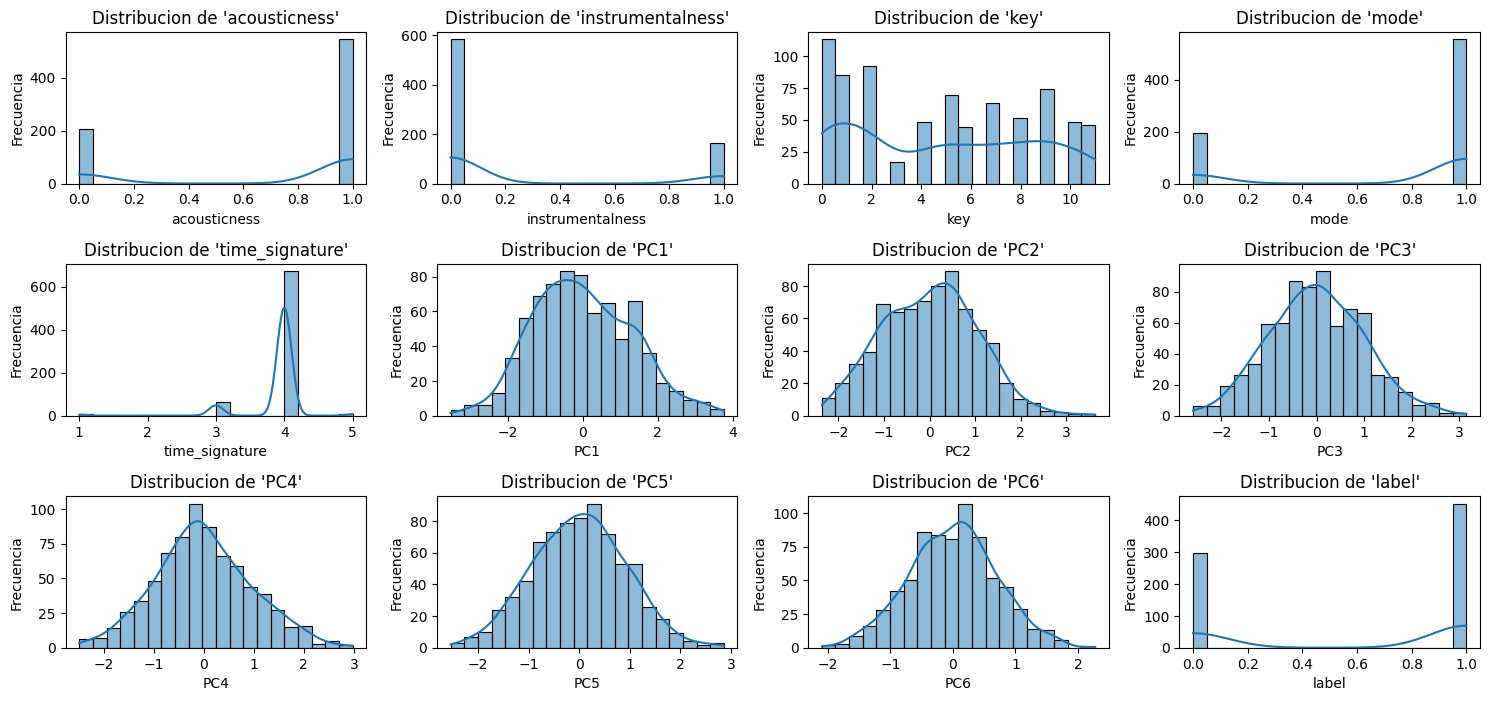

In [142]:
# Calcular el número de filas necesarias para acomodar todas las variables.
num_variables = len(final_df.columns)
num_rows = -(-len(final_df.columns) // 5)  #Para garantizar que se tracen todas las variables.

# Crear una sola figura con 5 columnas.
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 3*num_rows))

# Aplana la matriz de ejes si num_rows es 1, para que pueda indexarse ​​de manera consistente
axes = axes.flatten() if num_rows > 1 else [axes]

# Iterar a través de cada variable y trazar
for i, column in enumerate(final_df.columns):
    ax = axes[i]  # Seleccionar el subplot apropiado
    sns.histplot(final_df[column], kde = True, ax = ax, bins = 20)  # Histograma con KDE
    ax.set_title(f"Distribucion de '{column}'")
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

# Ocultar subplots no utilizados
fig.delaxes(axes[14])
fig.delaxes(axes[15])
fig.delaxes(axes[13])
fig.delaxes(axes[12])

plt.tight_layout()  # Ajustar Layout para evitar superposiciones
plt.show()

In [175]:
scaler = StandardScaler()
pca_model = PCA(n_components=1)
df = pd.read_csv(enlace_drive)
df1 = df.copy()
df2 = df.copy()

#-----#
# quitar la columna label antes de aplicar modificaciones al dataset
df1 = df.drop(columns=['label'])

#-----#
# manejo de outliers: capping (limitarlos al +- 1.5IQR)
    # IDEA DE VISUALIZACION
    # MOSTRAR BOX PLOTS ANTES Y DESPUES DE CAPPING
df1 = handle_outliers(df1, 'Capping')

#-----#
# normalizacion de variables por yeo johnson
# OBSERVACION: agregar normalizacion hace que los resultados del modelo empeoren. Considerar dejarlo como comentario y/o hacer comentarios al respecto
    # IDEA DE VISUALIZACION
    # MOSTRAR UN PLOT DE DENSIDADES PARA MOSTRAR EL CAMBIO DE CADA VARIABLE
#df1, _ = transform_data(df1, 'yeo-johnson', 0.05)

#-----#
# quitamos estas variables que vamos a tratar de distinta manera
df1.drop(['tempo','key','mode','duration','instrumentalness','liveness','time_signature','acousticness', 'energy', 'loudness'], axis = 1, inplace = True)

#-----#
# las variables tempo, key, mode, duration, instrumentalness, liveness y time_signature tienen una correlacion muy baja con label (ver matriz de correlacion)
# vamos a tratar de aplicar PCA para reducirlas todas a una sola variable, de esa forma mantenemos algo de la informacion pero reducimos la cantidad de features
pca1 = df[['tempo', 'key', 'mode', 'duration', 'instrumentalness', 'liveness','time_signature']]

#-----#
# las variables acousticness, energy y loudness tienen una alta correlacion (ver matriz de correlacion)
# vamos a tratar de aplicar PCA para evitar redundancias
# la otra opcion es eliminar dos de ellas (yo eliminaria acousticness y energy, ya que loudness es la que mas se parece a una distribucion normal)
pca2 = df[['acousticness', 'energy', 'loudness']]

#-----#
pca1 = scaler.fit_transform(pca1)
pca2 = scaler.fit_transform(pca2)

#-----#
# al aplicar PCA, el explained variance ratio nos dice que para explicar el 90% de la varianza necesitamos 7 componentes, que es la misma cantidad de variables a las cuales les estamos aplicando PCA
# esto significa que estas variables en verdad no aportan mucho
    # IDEA DE VISUALIZACION
    # CAMBIAR EL NUMERO DE COMPONENTES DE PCA Y GRAFICAR EL EXPLAINED_VARIANCE_RATIO_ CONTRA LA CANTIDAD DE COMPONENTES (PARA QUE SE VEA QUE TODAS EXPLICAN CASI LA MISMA VARIANZA)
pca1 = pca_model.fit_transform(pca1)
#print(pca_mod.explained_variance_ratio_)

#-----#
# en este caso, el explained variance ratio nos dice que explicamos el ~85% con un solo componente, por lo que aplicar PCA funcionó
    # IDEA DE VISUALIZACION
    # LO MISMO QUE EL ANTERIOR, PERO EN ESTE CASO DEMOSTRAMOS QUE LAS 3 VARIABLES FACILMENTE SE EXPLICAN CON 1 SOLA
pca2 = pca_model.fit_transform(pca2)
#print(pca_mod.explained_variance_ratio_)

#-----#
# no agregamos pca1 al dataset por lo mencionado anteriormente, estas variables no aportan informacion
df1['pca1'] = pca1
df1['pca2'] = pca2

#-----#
# x1,y1 es el dataset modificado mientras que x2,y2 es el dataset original
x1 = df1
y1 = df['label']
x2 = df2.drop(columns=['label'])
y2 = df['label']

#-----#
# separamos en train y test
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression()
}

param_grid = {
    'Decision Tree': {'max_depth': [None, 5, 10, 20]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'max_iter': [None, 500]}
}

#-----#
# escalamos las variables (esto es especialmente importante para x2 ya que 'duration' no ha sido modificado y esta fuera de escala con respecto a las otras variables)
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)
x2_train = scaler.fit_transform(x2_train)
x2_test = scaler.transform(x2_test)

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression()
}

param_grid = {
    'Decision Tree': {'max_depth': [10, 20]},
    'Random Forest': {'n_estimators': [25, 50, 100], 'max_depth': [None, 5, 10]},
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'max_iter': [100, 200, 500, 1000]}
}

#-----#
# busqueda de los mejores hiperparametros
best_params1 = {}
best_params2 = {}
for name, model in models.items():
    grid_search1 = GridSearchCV(model, param_grid[name], cv=5)
    grid_search1.fit(x1_train, y1_train)
    best_params1[name] = grid_search1.best_params_
    
    grid_search2 = GridSearchCV(model, param_grid[name], cv=5)
    grid_search2.fit(x2_train, y2_train)
    best_params2[name] = grid_search2.best_params_

#-----#
# comparacion de modelos
    # OBSERVACION: LAS INDICACIONES DICEN QUE UN SOLO MODELO, QUIZAS DEBERIAMOS CONSIDERAR DEJAR UN SOLO MODELO
    # SOBRETODO TENIENDO EN CUENTA QUE HAY PREGUNTAS ASOCIADAS A "PORQUE ELEGISTE ESE MODELO" (LO CUAL HAY QUE AGREGAR, YA QUE NO ESTABA EN LA TAREA DE ANALISIS DE DATOS)
for name, model in models.items():
    model.set_params(**best_params1[name]) 
    model.fit(x1_train, y1_train) 
    y_pred_unmodified = model.predict(x1_test) 
    accuracy = accuracy_score(y1_test, y_pred_unmodified)  
    report = classification_report(y1_test, y_pred_unmodified, output_dict = True)
    accuracy = report['accuracy']
    print(f'Data modificada - {name} - Accuracy: {accuracy:.5f}')

    model.set_params(**best_params2[name])
    model.fit(x2_train, y2_train) 
    y_pred_modified = model.predict(x2_test)
    accuracy = accuracy_score(y2_test, y_pred_modified)  
    report = classification_report(y2_test, y_pred_modified, output_dict = True)
    print(f'Data completa - {name} - Accuracy: {accuracy:.5f}\n')

    # IDEA DE VISUALIZACION
    # AGREGAR CURVAS ROC
    # AGREGAR MATRIZ DE CONFUSION

Data modificada - Decision Tree - Accuracy: 0.81333
Data completa - Decision Tree - Accuracy: 0.74000

Data modificada - Random Forest - Accuracy: 0.85333
Data completa - Random Forest - Accuracy: 0.85333

Data modificada - Logistic Regression - Accuracy: 0.82000
Data completa - Logistic Regression - Accuracy: 0.78667

